In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import json
import pickle
import io
import pandas as pd
from dataclasses import asdict
from backdoors import data, patterns, poison, utils, checkpoint_dir
from backdoors.data import load_cifar10, Data
import numpy as np
import matplotlib.pyplot as plt
import einops
import jax
from jax import numpy as jnp
from flax.training import train_state
import optax
import chex
import flax
from flax import linen as nn
from typing import Tuple
import matplotlib.pyplot as plt
import sympy
from jax import random
from collections import namedtuple
from time import time

import orbax.checkpoint
import os
from pathlib import Path

from backdoors import image_utils
from backdoors import module_path, checkpoint_dir, train, paths
from backdoors.train import TrainState, Metrics, model, tx, \
    accuracy, train_step, init_train_state
from backdoors.models import CNN
from meta_transformer.data import load_batches
from tqdm import tqdm
rng = random.PRNGKey(0)

checkpointer = orbax.checkpoint.PyTreeCheckpointer()

BATCH_SIZE = 64
NUM_EPOCHS = 5

#train_data, _ = load_cifar10()
#cifar10_train, cifar10_test = load_cifar10()

/home/lauro/.virtualenvs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
@flax.struct.dataclass
class Test:
    a: int
    b: int

    def add1(self, t: Test):
        return Test(t.a + 1, t.b + 1)

    def prt(self, t: Test):
        print(t.a, t.b)

In [12]:
def process(t):
    return Test(t.a * 5, t.b + 5)

In [13]:
t = Test(1, 2)
t.process = process

FrozenInstanceError: cannot assign to field 'process'

In [9]:
@jax.jit
def ttest(t: Test):
    t = t.add1(t)
    return t

In [10]:
ttest(t)

Test(a=Array(3, dtype=int32, weak_type=True), b=Array(4, dtype=int32, weak_type=True))

In [ ]:
def process_batch(rng, batch: Data, poison_batch: bool = False) -> Data:
    # augment
    subrng, rng = jax.random.split(rng)
    batch = Data(image=process_batch(subrng, batch.image, augment=AUGMENT),
                 label=batch.label)
    # poison
    if poison_batch:
        subrng, rng = jax.random.split(rng)
        batch = poison(subrng, batch, target_label=target_label, poison_frac=0.01,
                       poison_type=poison_type)

In [47]:
# plot data
cifar10_train, cifar10_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [54]:
batch = cifar10_test[:16]
subrng, rng = jax.random.split(rng)
poisoned, _ = poison.poison(subrng, batch, target_label=-1, poison_frac=1., poison_type="simple_pattern")

Plotting...


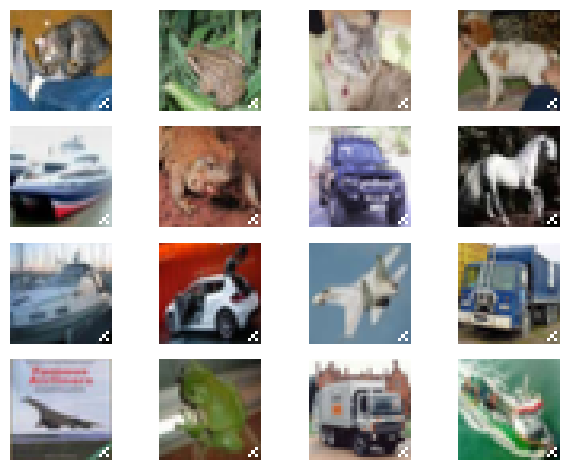

In [55]:
print("Plotting...")
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(poisoned.image[i + 4 * j])
        axs[i, j].axis("off")
plt.tight_layout()

In [57]:
subrng, rng = jax.random.split(rng)
augmented_imgs = image_utils.process_batch(subrng, poisoned.image, augment=True)

Plotting...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


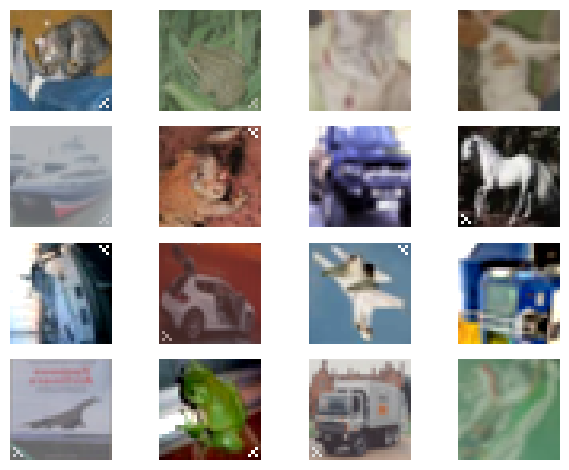

In [58]:
print("Plotting...")
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(augmented_imgs[i + 4 * j])
        axs[i, j].axis("off")
plt.tight_layout()

In [36]:
module_path

'/home/lauro/projects/meta-models/lauro-backdoors'

In [37]:
#bdir = paths.PRIMARY_BACKDOOR / "simple_pattern"
#cdir = paths.PRIMARY_CLEAN

base = Path(module_path) / "hpc-checkpoints" / "primary"
bdir = base / "backdoor/simple_pattern"
cdir = base / "clean/clean_0"

bbatches = load_batches(bdir)
cbatches = load_batches(cdir)

In [38]:
backdoor_accs = [b["info"]["test_accuracy"] for b in bbatches]
clean_accs = [b["info"]["test_accuracy"] for b in cbatches]

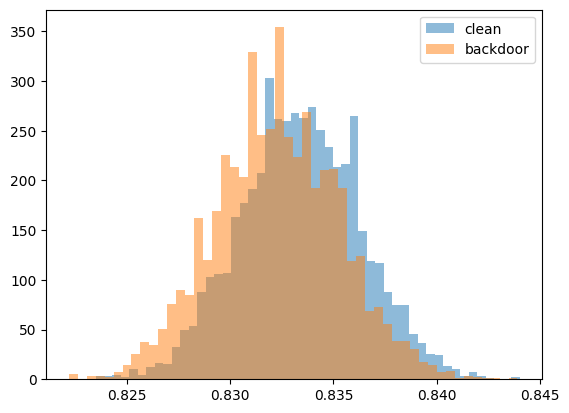

In [42]:
plt.hist(clean_accs, bins=50, alpha=0.5, label="clean")
plt.hist(backdoor_accs, bins=50, alpha=0.5, label="backdoor")
plt.legend()

In [44]:
len(clean_accs), len(backdoor_accs)

(4950, 4850)

In [41]:
np.mean(clean_accs) - np.mean(backdoor_accs)

0.0011328345308757592